In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve
import numpy as np


In [2]:
data = pd.read_csv('iris_data.csv')
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   149 non-null    float64
 2   Petal.Length  149 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


There's 2 missing values in total in
two columns


In [4]:
data['Sepal.Width'] = data['Sepal.Width'].fillna(data['Sepal.Width'].mean())
data['Petal.Length'] = data['Petal.Length'].fillna(data['Petal.Length'].mean())


In [5]:
data.isnull().sum()

,0
Sepal.Length,0
Sepal.Width,0
Petal.Length,0
Petal.Width,0
Species,0


In [6]:
numeric_cols = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
X = data[numeric_cols]
y = LabelEncoder().fit_transform(data['Species'])


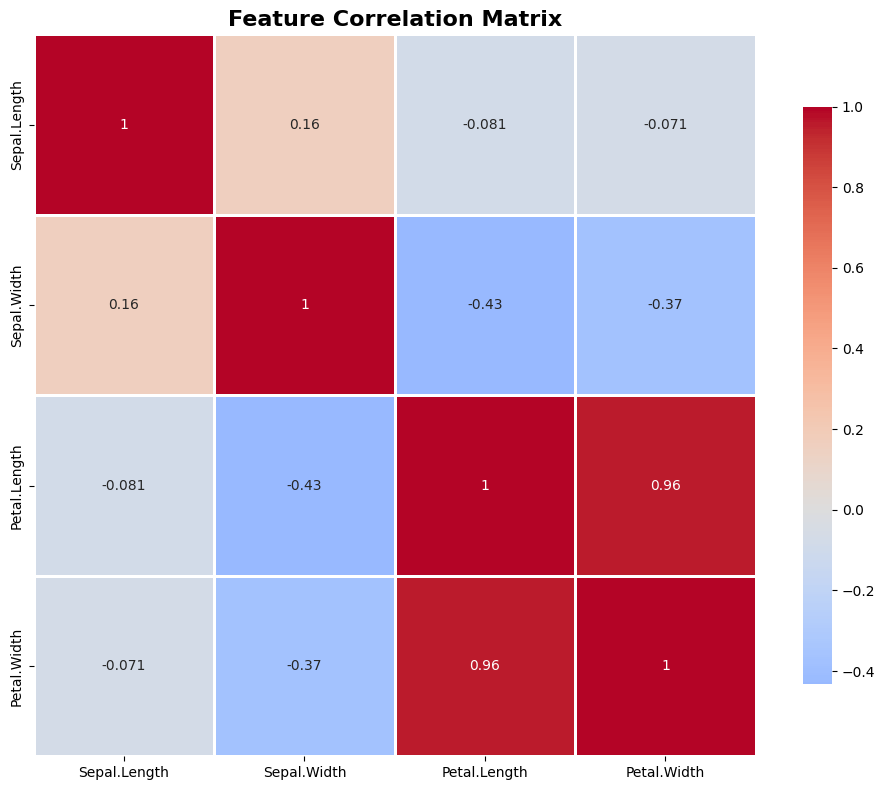

In [7]:
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Over Here we can observe that there is a high correlation in between Petal.width and Petal.length which lead to high multicollinearity


In [9]:
high_corr_threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > high_corr_threshold)]

In [10]:
print(to_drop)

['Petal.Width']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return lower_bound, upper_bound, outliers


We'll Visualize the outliers in each features



Outlier Analysis (IQR Method):
------------------------------------------------------------


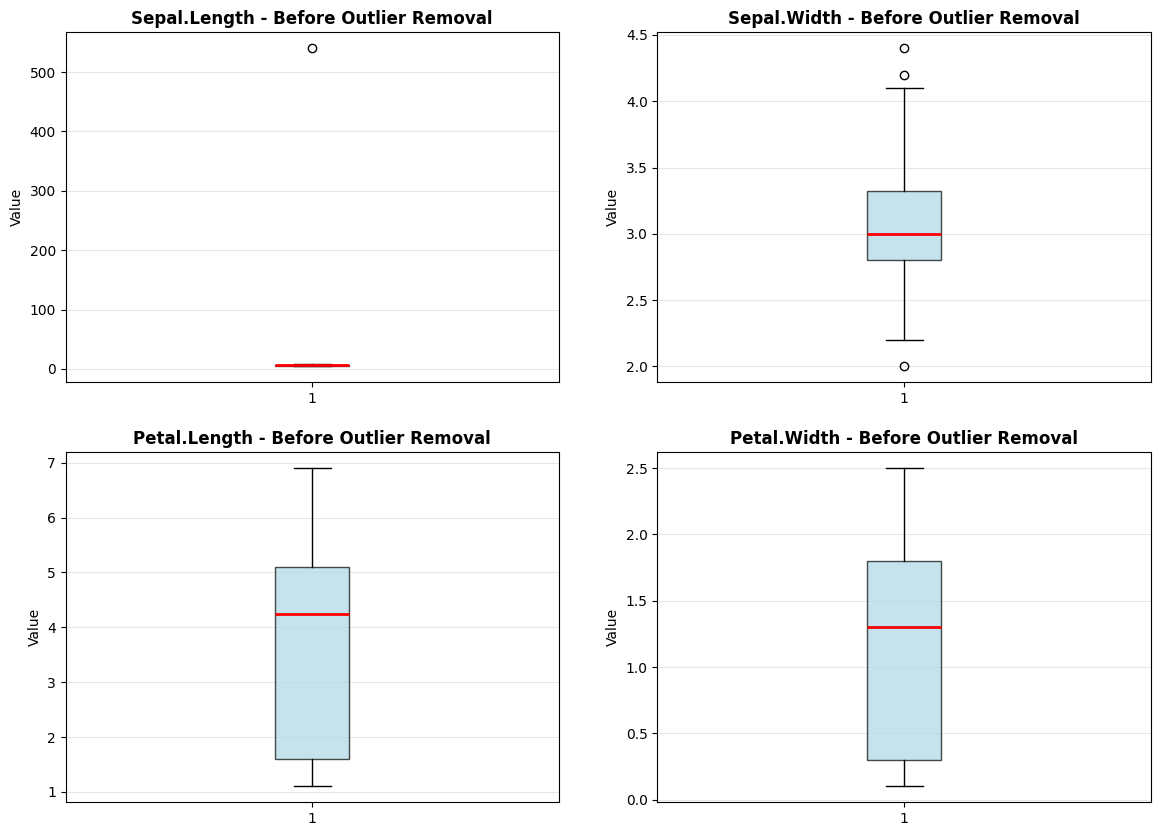

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

print("\nOutlier Analysis (IQR Method):")
print("-" * 60)

outlier_info = {}
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(X_train[col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col} - Before Outlier Removal', fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(axis='y', alpha=0.3)

    lower, upper, outliers = detect_outliers_iqr(X_train, col)
    outlier_info[col] = {
        'lower_bound': lower,
        'upper_bound': upper,
        'n_outliers': len(outliers)
    }


We can notice that there are high outliers in Sepal.Length and Sepal.Width

In [18]:
print(len(outliers))
print(lower)
print(upper)
if len(outliers) > 0:
        print(f"  Outlier values: {outliers[col].values}")


0
-1.95
4.05


We will create a mask for rows without any outliers


In [19]:
mask = pd.Series([True] * len(X_train), index=X_train.index)

for col in numeric_cols:
    lower = outlier_info[col]['lower_bound']
    upper = outlier_info[col]['upper_bound']
    mask &= (X_train[col] >= lower) & (X_train[col] <= upper)

X_train_clean = X_train[mask]
y_train_clean = y_train[mask.values]


In [21]:
print(f"Original:{len(X_train)}")
print(f"Cleaned:{len(X_train_clean)}")
print(f"data removed:{len(X_train) - len(X_train_clean)}")

Original:120
Cleaned:116
data removed:4


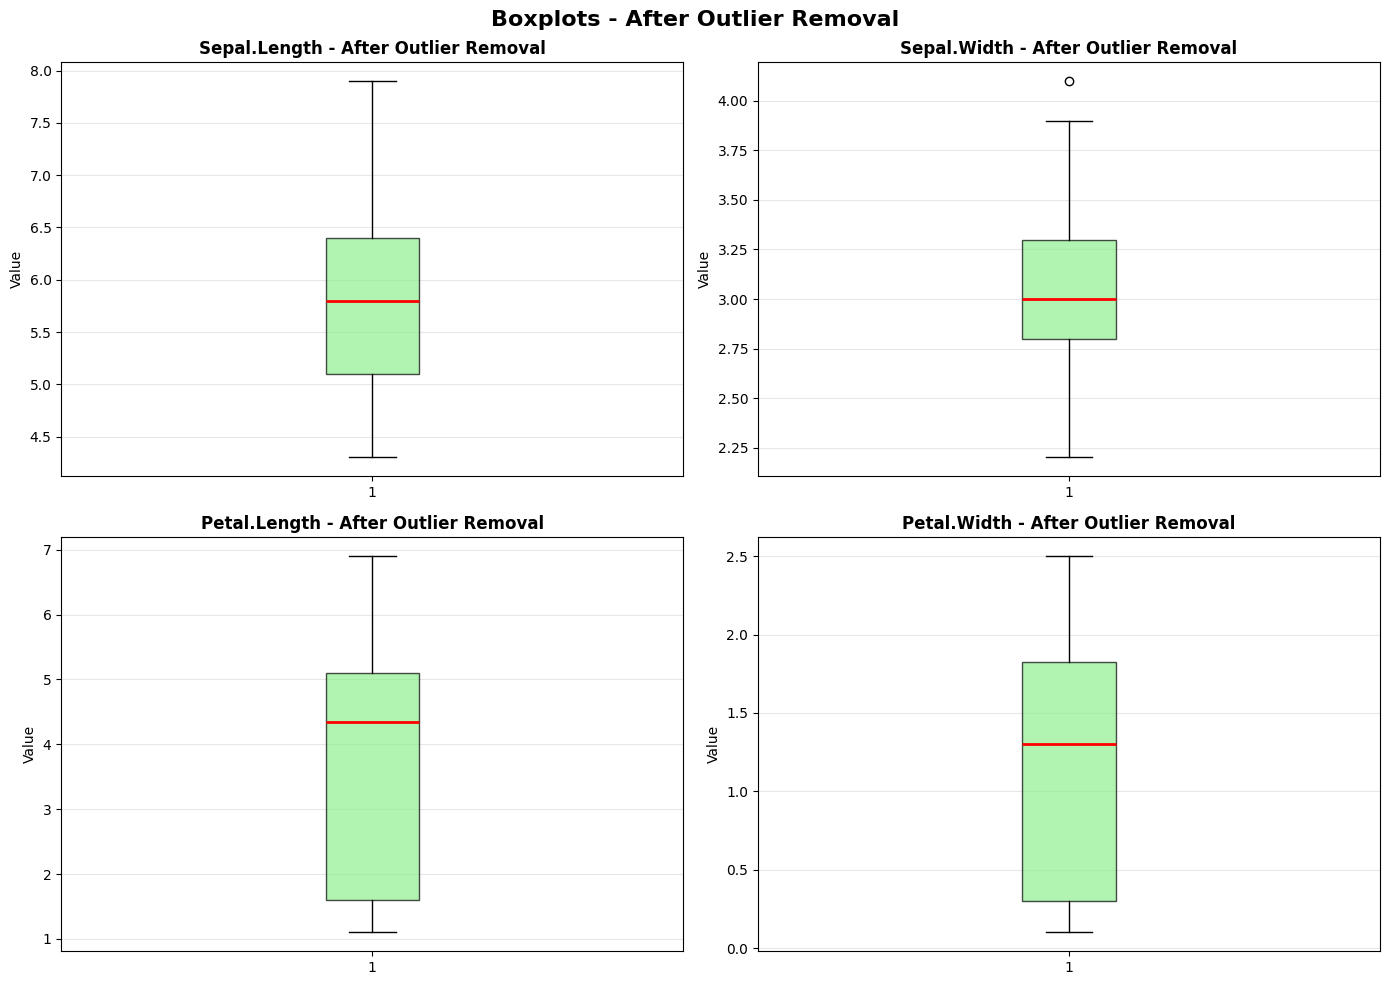

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    # Create boxplot
    axes[idx].boxplot(X_train_clean[col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col} - After Outlier Removal', fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Boxplots - After Outlier Removal', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('boxplots_after_outlier_removal.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
X_train = X_train_clean
y_train = y_train_clean

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i)
              for i in range(X_train.shape[1])]
vif = vif.sort_values('VIF', ascending=False)

In [25]:
print(vif)

        Feature         VIF
0  Sepal.Length  202.483953
2  Petal.Length  125.323679
1   Sepal.Width   75.585253
3   Petal.Width   41.839406


After removal of the outliers the features shows a high multicolinearity,so we will compare two models one with all 4 features and other with removed features


In [26]:
high_vif_features = vif[vif['VIF'] > 10]['Feature'].tolist()
print(high_vif_features)

['Sepal.Length', 'Petal.Length', 'Sepal.Width', 'Petal.Width']


we will code a common logic to check the feature with max VIF and remove the feature with th highest vif

In [32]:
if high_vif_features:
    X_train_reduced = X_train.copy()
    removed_features = []

    while True:
        temp_vif = pd.DataFrame()
        temp_vif['Feature'] = X_train_reduced.columns
        temp_vif['VIF'] = [variance_inflation_factor(X_train_reduced.values, i)
                          for i in range(X_train_reduced.shape[1])]
        #max vif
        max_vif = temp_vif['VIF'].max()

        if max_vif <= 10:
            break

        #remove features with high vif
        feature_to_remove = temp_vif.loc[temp_vif['VIF'].idxmax(), 'Feature']
        removed_features.append(feature_to_remove)


        X_train_reduced = X_train_reduced.drop(columns=[feature_to_remove])
        if len(X_train_reduced.columns) < 2:
            print("\nWarning: Stopped removal to maintain at least 2 features")
            break
    vif_reduced = pd.DataFrame()
    vif_reduced['Feature'] = X_train_reduced.columns
    vif_reduced['VIF'] = [variance_inflation_factor(X_train_reduced.values, i)
                          for i in range(X_train_reduced.shape[1])]
    vif_reduced = vif_reduced.sort_values('VIF', ascending=False)
    print(vif_reduced)

    X_test_reduced = X_test[X_train_reduced.columns]
    X_train_full = X_train.copy()
    X_test_full = X_test.copy()
else:
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()
    X_train_full = X_train.copy()
    X_test_full = X_test.copy()
    removed_features = []


       Feature      VIF
1  Petal.Width  3.08068
0  Sepal.Width  3.08068


So the Petal.length and Sepal.Length got removed as they had high VIF which was not good for training the model


Logistic Regression Model


In [33]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model.fit(X_train_reduced, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [35]:
y_pred = model.predict(X_test_reduced)
y_pred_proba = model.predict_proba(X_test_reduced)

In [37]:
train_accuracy = model.score(X_train_reduced, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(train_accuracy)
print(test_accuracy)

0.9568965517241379
0.9


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.89      0.80      0.84        10
           2       0.82      0.90      0.86        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



Class 0 -> Setosa

Class 1 -> Versicolo

Class 2 -> virginica

For Class 0 :model predict perfectly on the test set

For Class 1:Model is reasonably good identifies 80 percent of the positive cases

For Class 2:Recall is high which is good most of the class are correctlt identified

In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)



Confusion Matrix:
[[10  0  0]
 [ 0  8  2]
 [ 0  1  9]]


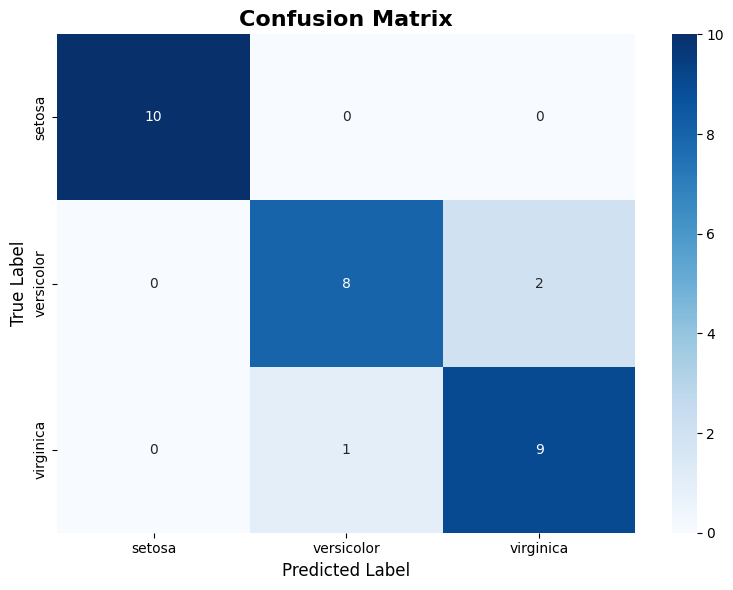

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data['Species'].unique(),
            yticklabels=data['Species'].unique())
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1200x600 with 0 Axes>

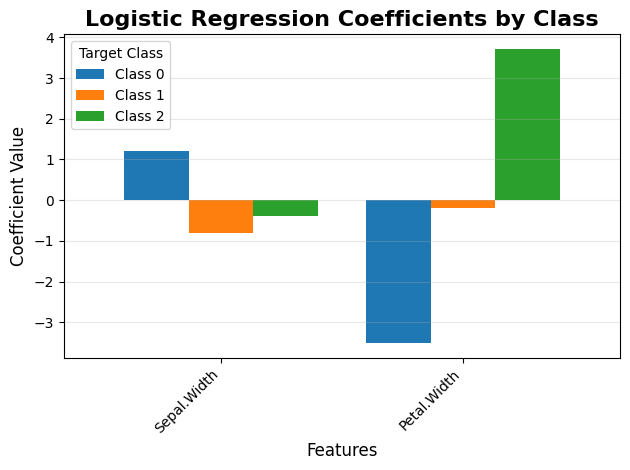

In [42]:
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame(
    model.coef_.T,
    columns=[f'Class {i}' for i in model.classes_],
    index=X_train_reduced.columns
)
coef_df.plot(kind='bar', width=0.8)
plt.title('Logistic Regression Coefficients by Class', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Target Class')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
species_names = data['Species'].unique()


<Figure size 1000x800 with 0 Axes>

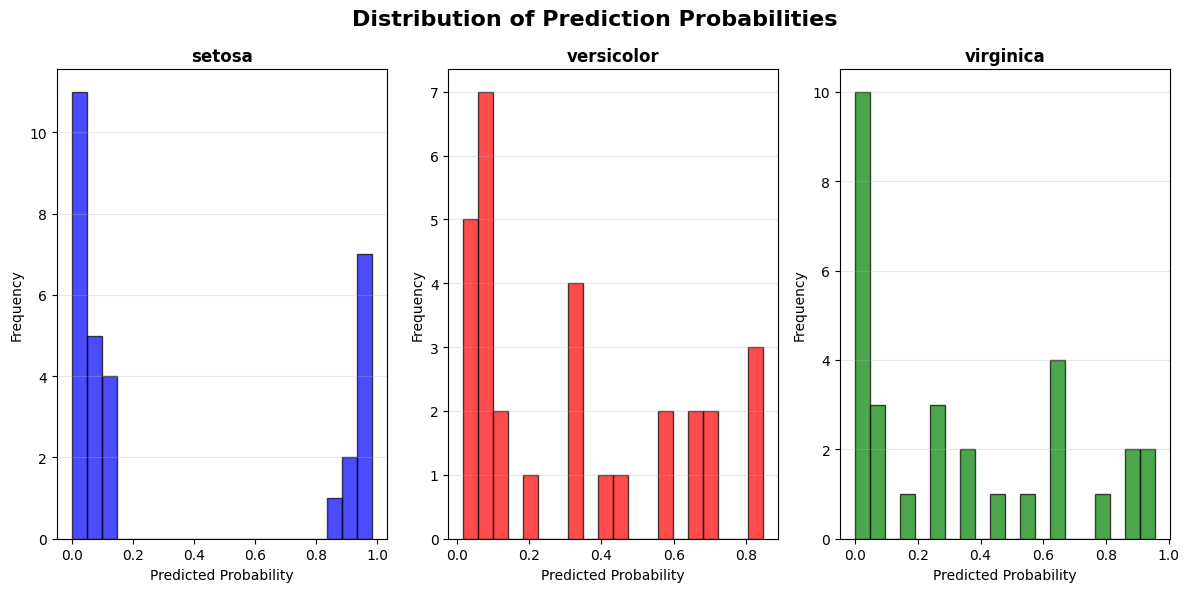

In [46]:

plt.figure(figsize=(12, 6))
for i, species in enumerate(species_names):
    plt.subplot(1, 3, i+1)
    plt.hist(y_pred_proba[:, i], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
    plt.title(f'{species}', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(axis='y', alpha=0.3)
plt.suptitle('Distribution of Prediction Probabilities', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipython-input-3058909289.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


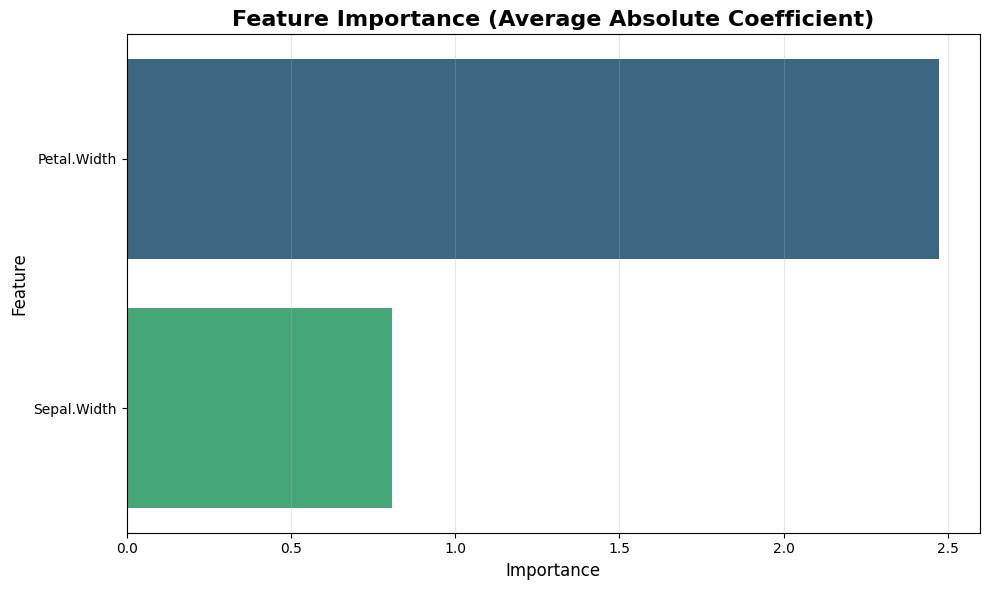

In [48]:
feature_importance = np.abs(model.coef_).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Average Absolute Coefficient)',
          fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

We have to make a Rule based approach,there are two way by writing in an IF ELSE block for length and width of the petal and sepal and also we can use decisiontree

In [52]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
rule_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
rule_tree.fit(X_train, y_train)
y_pred_rules = rule_tree.predict(X_test)
rules_acc = accuracy_score(y_test, y_pred_rules)
print(f"\nDecision Tree (shallow) Accuracy: {rules_acc:.3f}")



Decision Tree (shallow) Accuracy: 0.967


In [53]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
rule_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
rule_tree.fit(X_train_reduced, y_train)
y_pred_rules = rule_tree.predict(X_test_reduced)
rules_acc = accuracy_score(y_test, y_pred_rules)
print(f"\nDecision Tree (shallow) Accuracy: {rules_acc:.3f}")



Decision Tree (shallow) Accuracy: 0.933


Over here we are seeing two accuracy it's beacuse of the outlier removal

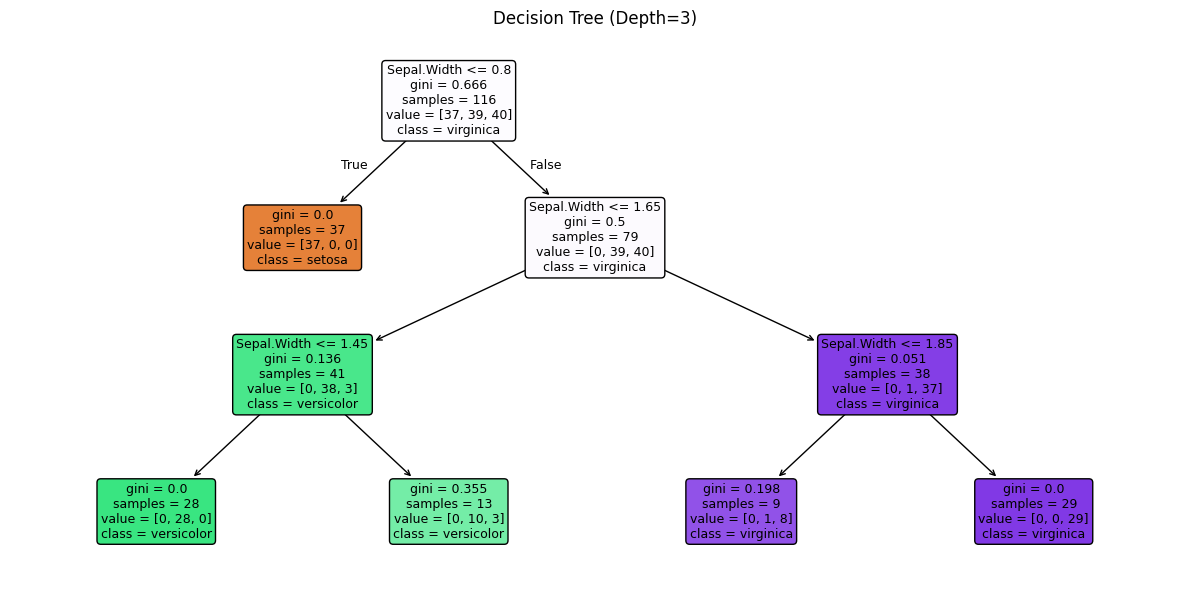

In [54]:
plt.figure(figsize=(12, 6))
plot_tree(rule_tree,
          feature_names=X_train.columns,
          class_names=data['Species'].unique(),
          filled=True, rounded=True, fontsize=9)
plt.title('Decision Tree (Depth=3)')
plt.tight_layout()
plt.show()


From the Decision Tree we can inherit the following Rules

In [59]:
species_stats = []
for species_idx, species_name in enumerate(data['Species'].unique()):
    species_data = X[y == species_idx]
    stats = {
        'Species': species_name,
        'Petal.Length_mean': species_data['Petal.Length'].mean(),
        'Petal.Length_min': species_data['Petal.Length'].min(),
        'Petal.Length_max': species_data['Petal.Length'].max(),
        'Petal.Width_mean': species_data['Petal.Width'].mean(),
        'Petal.Width_min': species_data['Petal.Width'].min(),
        'Petal.Width_max': species_data['Petal.Width'].max(),
        'Sepal.Length_mean': species_data['Sepal.Length'].mean(),
        'Sepal.Width_mean': species_data['Sepal.Width'].mean(),
    }
    species_stats.append(stats)

species_df = pd.DataFrame(species_stats)
print("\nSIMPLE RULES")

petal_length_threshold_1 = species_df.loc[species_df['Species'] == 'setosa', 'Petal.Length_max'].values[0]
petal_length_threshold_2 = (species_df.loc[species_df['Species'] == 'versicolor', 'Petal.Length_mean'].values[0] +
                             species_df.loc[species_df['Species'] == 'virginica', 'Petal.Length_mean'].values[0]) / 2

print("RULE 1: Measure the PETAL LENGTH (in cm)")
print(f"  • If Petal Length ≤ {petal_length_threshold_1:.1f} cm")
print(f"    → Species: SETOSA")
print(f"    → Confidence: Very High (Setosa has distinctly short petals)")
print()
print(f"  • If Petal Length > {petal_length_threshold_1:.1f} cm")
print(f"    → Go to RULE 2 (distinguish Versicolor vs Virginica)")
print()

petal_width_threshold = (species_df.loc[species_df['Species'] == 'versicolor', 'Petal.Width_mean'].values[0] +
                         species_df.loc[species_df['Species'] == 'virginica', 'Petal.Width_mean'].values[0]) / 2

print("RULE 2: Measure the PETAL WIDTH (in cm)")
print(f"  • If Petal Width ≤ {petal_width_threshold:.1f} cm")
print(f"    → Species: VERSICOLOR")
print(f"    → Confidence: High")
print()
print(f"  • If Petal Width > {petal_width_threshold:.1f} cm")
print(f"    → Species: VIRGINICA")
print(f"    → Confidence: High")
print()



SIMPLE RULES
RULE 1: Measure the PETAL LENGTH (in cm)
  • If Petal Length ≤ 3.8 cm
    → Species: SETOSA
    → Confidence: Very High (Setosa has distinctly short petals)

  • If Petal Length > 3.8 cm
    → Go to RULE 2 (distinguish Versicolor vs Virginica)

RULE 2: Measure the PETAL WIDTH (in cm)
  • If Petal Width ≤ 1.7 cm
    → Species: VERSICOLOR
    → Confidence: High

  • If Petal Width > 1.7 cm
    → Species: VIRGINICA
    → Confidence: High



In [62]:
def classify_with_rules(petal_length, petal_width):
    if petal_length <= petal_length_threshold_1:
        return 0  # Setosa
    elif petal_width <= petal_width_threshold:
        return 1  # Versicolor
    else:
        return 2  # Virginica

# Apply rules to test set
y_pred_simple = [classify_with_rules(pl, pw)
                 for pl, pw in zip(X_test['Petal.Length'], X_test['Petal.Width'])]
simple_rules_accuracy = accuracy_score(y_test, y_pred_simple)


print(f"\nRule Algorithm Accuracy: {simple_rules_accuracy:.4f} ({simple_rules_accuracy*100:.2f}%)")
print(f"Logistic Regression Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Accuracy difference: {abs(test_accuracy - simple_rules_accuracy)*100:.2f}%")





Rule Algorithm Accuracy: 0.8667 (86.67%)
Logistic Regression Accuracy: 0.9000 (90.00%)
Accuracy difference: 3.33%


In [67]:
n_classes = np.unique(y).shape[0]
print(f"""
Model Performance:
- Training Accuracy: {train_accuracy*100:.2f}%
- Test Accuracy: {test_accuracy*100:.2f}%
- Number of Features: {X.shape[1]}
- Number of Samples: {X.shape[0]}
- Number of Classes: {n_classes}
""")



Model Performance:
- Training Accuracy: 95.69%
- Test Accuracy: 90.00%
- Number of Features: 4
- Number of Samples: 150
- Number of Classes: 3



Observations:
1. petal.Length and petal.Width show high multicollinearity (VIF > 10)
   but both are important predictors for classification.
2. model achieves excellent performance on the test set.

In [72]:
def predict_from_user_input(model):
    try:
        sepal_length = float(input("Enter Sepal Length (cm): "))
        sepal_width  = float(input("Enter Sepal Width  (cm): "))
        petal_length = float(input("Enter Petal Length (cm): "))
        petal_width  = float(input("Enter Petal Width  (cm): "))
    except ValueError:
        print("\n Invalid.")
        return
    features_dict = {'Sepal.Length': sepal_length,
                     'Sepal.Width': sepal_width,
                     'Petal.Length': petal_length,
                     'Petal.Width': petal_width}

    model_features = model.feature_names_in_
    features = np.array([[features_dict[feature] for feature in model_features]])

    prediction = model.predict(features)[0]

    species_names = ['setosa', 'versicolor', 'virginica']
    predicted_species = species_names[prediction]

    print("\n Prediction Result:")
    print(f"🌼 The predicted Iris species is: **{predicted_species.upper()}**")

predict_from_user_input(rule_tree)

Enter Sepal Length (cm): 5.8
Enter Sepal Width  (cm): 3.4
Enter Petal Length (cm): 5
Enter Petal Width  (cm): 2

 Prediction Result:
🌼 The predicted Iris species is: **VIRGINICA**


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
